In [1]:
import os
import sys
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
import h5py
import numpy as np
import numpy.fft as nf
import pytorch_ssim
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.unet.unet_model import UnetModel as UnetModel
from FF_net import FF_net
from FF_net import FF_simple_net
from FF_net import FF_net_tanh
from FF_net import Complex_net
import argparse
from common.args import Args
import models.unet.run_unet  as Run
import torch.nn as nn
import logging
import pathlib
import random
from torch.utils.data import Dataset
import time
from torch.nn import functional as F
import shutil
from tensorboardX import SummaryWriter
import torchvision
from torchvision import transforms, utils
import net_utils as nu
import calendar
import datetime
from longOne import ComplexFourier,ComplexEndToEnd
from complex_unet_model import ComplexUnetModel
from complex_end_to_end import ComplexEndToEnd

import sigpy as sp
import sigpy.plot as pl
from skimage.metrics import structural_similarity as np_ssim
import vd_spiral

from FF_net import Complex_net_ext

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
sys.argv=['']
def create_arg_parser():
    timestamp = calendar.timegm(time.gmtime())
    human_readable = datetime.datetime.fromtimestamp(timestamp).isoformat()
    #human_readable="pure_inverse_fourier"
    human_readable="ComplexEndToEnd_Kspace"
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=8, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=250, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=100,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.01,
                        help='Strength of weight decay regularization')
    parser.add_argument('--momentum', type=float, default=0.1,
                        help='Strength of optimizer momentum')

    parser.add_argument('--report-interval', type=int, default=10000, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cuda',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable),
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_'+str(human_readable)+'/best_model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/ff_lrelu_'+str(human_readable),
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=128, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[0,1] , help='GPUS used')
    return parser
args=create_arg_parser().parse_args()
print("save to",args.checkpoint)

save to /mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd_Kspace/best_model.pt


In [3]:
def test_fourier():
    sig = np.random.randn(args.resolution) + 1j*np.random.randn(320)
    F = np.fft.ifft(sig, axis=-1)
    # First half of inputs/outputs is real part, second half is imaginary part
    X = torch.from_numpy(np.hstack([sig.real, sig.imag])).double()
    Y = torch.from_numpy((F.real**2+F.imag**2)**(1/2)).double()
    return X,Y

class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """
    
    def __init__(self, root="/mnt/mnt/5TB_slot2/fastMRI/multicoil_train", sample_rate=1.):
        self.examples = []
        #potential to apply pre-process transform
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            #random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            print(fname)
            try:
                #print(h5py.File(fname, 'r').keys())
                #maybe also only randomly select parts of slices. Otherwise lot of outer noise-like structures.
                xml = h5py.File(fname, 'r')['ismrmrd_header']
                kspace = h5py.File(fname, 'r')['kspace']
                num_slices = kspace.shape[0]
                num_channels=kspace.shape[1]
                if (kspace.shape[-2]<args.resolution) or (kspace.shape[-1]<args.resolution):# or num_channels!=16:
                    continue
                print(len(self.examples))
                for slice in range(num_slices):
                    crop_size = (min(args.resolution, kspace.shape[-2]),min(args.resolution, kspace.shape[-1]))
                    k=nu.center_crop(kspace[slice], crop_size)[0]
                    target=abs(nu.make_ift(k))
                    m=np.max(target)
                    if m>0:
                        target/=m
                    else:
                        continue
                    k=nu.to_tensor(k).unsqueeze(0)
                    us=nu.apply_mask(k,r=3)[0]#*args.resolution
                    us/=m
                    if np.isnan(np.sum(target)):
                        continue
                    X=us#.flatten()
                    print(X.shape)
                    #print(X.shape)
                    Y=nu.to_tensor(target)
                    #print(Y.shape)
                    #X,Y=test_fourier()
                    self.examples += [(fname, slice, X, Y)]
            except:
                print("Couldn't open file")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, i):
        fname, slice, f, t = self.examples[i]
#         with h5py.File(fname, 'r') as data:
#             full=to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, full.shape[-3]),min(args.resolution, full.shape[-2]))          
#             full=complex_center_crop(full,crop_size)
            
#             kspace = to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, kspace.shape[-3]), min(args.resolution, kspace.shape[-2]))
#             kspace=apply_mask(kspace)[0]
#             kspace = complex_center_crop(kspace, crop_size)
            
        return (f, t)

In [4]:
def create_data_loaders():
    #batch_size=32
    #mask_func = None
    #if args.mask_kspace:
    #    mask_func = MaskFunc(args.center_fractions, args.accelerations)
    train_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_train",sample_rate=0.05)
    dev_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.05)
    test_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.05)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    test_loader=None
#     test_loader = DataLoader(
#         dataset=test_data,
#         num_workers=0,
#         pin_memory=True,
#     )
    return train_loader, dev_loader, test_loader

In [5]:
t=time.time()
train_loader, dev_loader, test_loader= create_data_loaders()
print("Time taken to load data: ",time.time()-t)

/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002496.h5
0
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002506.h5
16
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2]

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000479.h5
247
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000626.h5
263
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
t

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_200_6002625.h5
0
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_201_6002891.h5
16
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 12

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002250.h5
238
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_201_2010233.h5
254
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_201_6002671.h5
48
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_202_6000378.h5
62
torch.Size([1,

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_202_2020373.h5
286
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128, 2])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_202_2020588.h5
302
torch.Size([1, 128, 

with torch.no_grad():
        for (f, t) in train_loader:
            print(f.shape,t.shape)
            plt.imshow(abs(nu.make_ift(nu.to_complex(f)))[0,0,:,:])
            plt.show()
            plt.imshow(t[0,:,:])
            plt.show()

In [60]:
def build_model(args,chans=args.num_chans,num_pool_layers=args.num_pools,drop_prob=0.05):
    #check every time which gpus are available!
    #device_ids=[2,3,1]
    device_ids=args.device_ids
    model=ComplexEndToEnd(in_chans=1,out_chans=1,chans=args.num_chans,num_pool_layers=args.num_pools,drop_prob=args.drop_prob,resolution=args.resolution).to(args.device)
    model=model.double()
    set_weights(model)
    if args.data_parallel and args.device=="cuda":
        model = nn.DataParallel(model,device_ids=device_ids)
    print("Model build successfully")
    #vis_weights(model)
    return model

def set_weights(model):
    model.f_layer1.conv_r.weight=torch.nn.Parameter(torch.tensor(np.load("module.c_layer1.conv_r.weight.npy")).to(args.device))
    model.f_layer1.conv_i.weight=torch.nn.Parameter(torch.tensor(np.load("module.c_layer1.conv_i.weight.npy")).to(args.device))
    model.f_layer2.conv_r.weight=torch.nn.Parameter(torch.tensor(np.load("module.c_layer2.conv_r.weight.npy")).to(args.device))
    model.f_layer2.conv_i.weight=torch.nn.Parameter(torch.tensor(np.load("module.c_layer2.conv_i.weight.npy")).to(args.device))

def vis_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
            # Heat map of neuron weights
            plt.imshow(param.data.cpu(), vmin=np.min(param.data.cpu().numpy()), vmax=np.max(param.data.cpu().numpy()), cmap='coolwarm')
            plt.show()
#            fig,ax=plt.subplots(320,1,figsize=(16,16))
#             for i in range(320):
#                 ax[i].plot(param.data.cpu()[i,:320])
#             plt.show()

def build_optim(args,params):
    optimizer = torch.optim.Adadelta(params)
    return optimizer

def load_model(checkpoint_file,args):
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = build_model(args)
    model.load_state_dict(checkpoint['model'])

    optimizer = build_optim(args, model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Model load successfully")
    return checkpoint, model, optimizer

def save_model(args, exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'args': args,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir / 'model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir / 'model.pt', exp_dir / 'best_model.pt')
        
def eval_loss(output,target):
    l1=F.l1_loss(output, target).item()
    #print(l1)
    mse=F.mse_loss(output, target).item()
    #print(mse)
    psnr=20*np.log10(np.max(target)/np.sqrt(mse))
    try:
        ssim=np_ssim(output.to("cpu").detach().numpy(), target.squeeze(1).to('cpu').detach().numpy())
    except:
        print(output.shape,target.shape)
        ssim=np_ssim(output[0].to("cpu").detach().numpy(), target[0].squeeze(1).to('cpu').detach().numpy())
    #print(ssim)
    return l1,mse,ssim,psnr

def visualize(args, epoch, model, data_loader, writer):
    def save_image(image, tag):
        image -= image.min()
        image /= image.max()
        grid = torchvision.utils.make_grid(image, nrow=4, pad_value=1)
        writer.add_image(tag, grid, epoch)
    model.eval()
    
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            input, target = data
            input = input.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            target = target.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            output = model(input)
            save_image(target[0,:,:], 'Target')
            save_image(output[0,:,:], 'Reconstruction')
            save_image(torch.abs(target - output)[0,:,:], 'Error')
            break

In [25]:
def train_epoch(args, epoch, model, data_loader, optimizer, writer):
    model.train()
    print(model.device_ids)
    avg_loss = 0.
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    for iter, data in enumerate(data_loader):
        f, t = data
        input = f.to(f'{args.device}:{model.device_ids[0]}')
        target = t.to(f'{args.device}:{model.device_ids[0]}')
        output_r,output_i = model(input)
        output = (output_r.squeeze(1)**2+output_i.squeeze(1)**2)**(1/2)
        
        loss = F.mse_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        writer.add_scalar('TrainLoss', loss.item(), global_step + iter)

#         if iter % args.report_interval == 0:
#             print(f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] ',
#                 f'Iter = [{iter:4d}/{len(data_loader):4d}] ',
#                 f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} ',
#                 f'Time = {time.perf_counter() - start_iter:.4f}s')
#             logging.info(
#                 f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] '
#                 f'Iter = [{iter:4d}/{len(data_loader):4d}] '
#                 f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} '
#                 f'Time = {time.perf_counter() - start_iter:.4f}s',
#             )
        start_iter = time.perf_counter()
    return avg_loss, time.perf_counter() - start_epoch

def evaluate(args, epoch, model, data_loader, writer):
    model.eval()
    losses = []
    all_losses = []
    start = time.perf_counter()
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            f, t = data
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            output_r,output_i = model(input)
            output = (output_r.squeeze(1)**2+output_i.squeeze(1)**2)**(1/2)

            #mean = mean.unsqueeze(1).unsqueeze(2).to(args.device)
            #std = std.unsqueeze(1).unsqueeze(2).to(args.device)
            #target = target * std + mean
            #output = output * std + mean

            #norm = norm.unsqueeze(1).unsqueeze(2).to(args.device)
            #loss = F.mse_loss(output / norm, target / norm, size_average=False)
            loss = F.mse_loss(output, target)
            losses.append(loss.item())
            all_losses.append(eval_loss(output,target))
        writer.add_scalar('Dev_Loss', np.mean(losses), epoch)
        print('Dev_Loss', np.mean(losses),'Epoch', epoch)
        print('L1_Loss', np.mean(all_losses[0]),"L2_Loss",np.mean(all_losses[1]),"SSIM_Loss",np.mean(all_losses[2]),"PSNR",np.mean(all_losses[3]),'Epoch', epoch)
    return np.mean(losses), time.perf_counter() - start

Model build successfully
[0, 1]
Dev_Loss 0.007515435744308624 Epoch 0
Epoch = [   0/ 250] TrainLoss = 0.005549  DevLoss = 0.007515 TrainTime = 436.6280s DevTime = 148.9945s


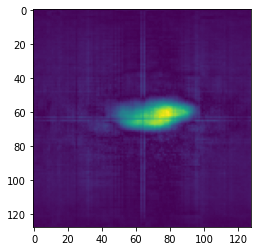

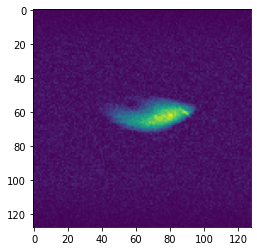

Time taken for epoch:  593.2132992744446
[0, 1]
Dev_Loss 0.008599652489700052 Epoch 1
Epoch = [   1/ 250] TrainLoss = 0.003103  DevLoss = 0.0086 TrainTime = 444.4501s DevTime = 159.7986s


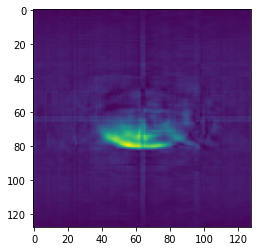

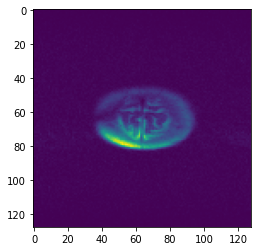

Time taken for epoch:  608.0114269256592
[0, 1]
Dev_Loss 0.0049592830049828545 Epoch 2
Epoch = [   2/ 250] TrainLoss = 0.002823  DevLoss = 0.004959 TrainTime = 445.0455s DevTime = 160.1361s


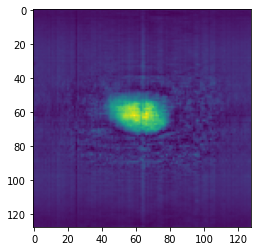

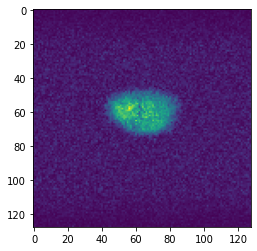

Time taken for epoch:  613.084009885788
[0, 1]
Dev_Loss 0.00454005596016196 Epoch 3
Epoch = [   3/ 250] TrainLoss = 0.002686  DevLoss = 0.00454 TrainTime = 444.7870s DevTime = 159.2588s


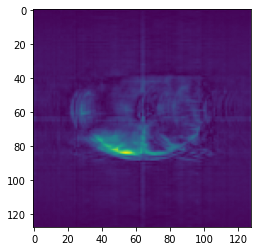

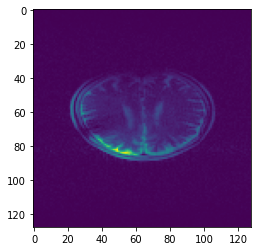

Time taken for epoch:  612.182590007782
[0, 1]
Dev_Loss 0.00376183691756858 Epoch 4
Epoch = [   4/ 250] TrainLoss = 0.002532  DevLoss = 0.003762 TrainTime = 444.6729s DevTime = 159.7441s


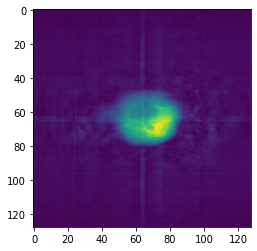

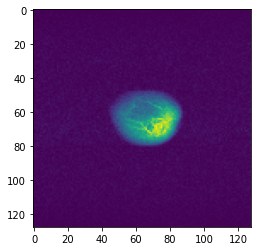

Time taken for epoch:  612.1353328227997
[0, 1]
Dev_Loss 0.003103494326708192 Epoch 5
Epoch = [   5/ 250] TrainLoss = 0.00244  DevLoss = 0.003103 TrainTime = 444.2222s DevTime = 175.5073s


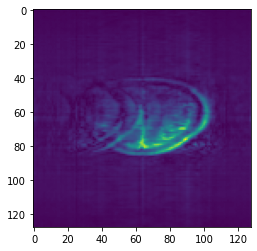

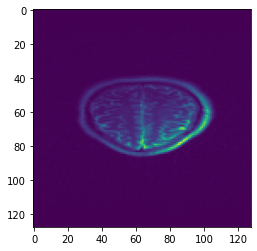

Time taken for epoch:  627.5659027099609
[0, 1]
Dev_Loss 0.0032925632417572 Epoch 6
Epoch = [   6/ 250] TrainLoss = 0.002442  DevLoss = 0.003293 TrainTime = 455.8328s DevTime = 167.7087s


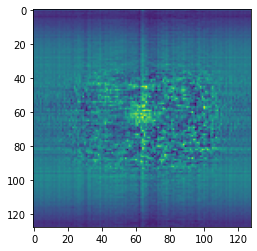

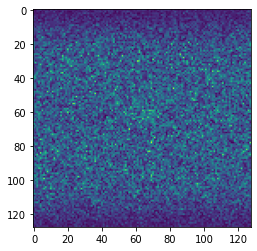

Time taken for epoch:  628.3466305732727
[0, 1]
Dev_Loss 0.0039420189920472 Epoch 7
Epoch = [   7/ 250] TrainLoss = 0.002529  DevLoss = 0.003942 TrainTime = 451.6424s DevTime = 158.2791s


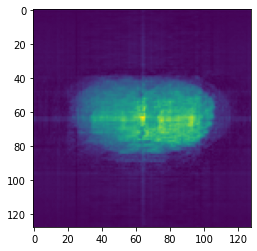

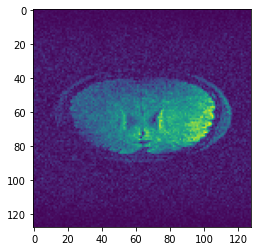

Time taken for epoch:  613.7101533412933
[0, 1]
Dev_Loss 0.0031778809879648546 Epoch 8
Epoch = [   8/ 250] TrainLoss = 0.002331  DevLoss = 0.003178 TrainTime = 432.3274s DevTime = 147.5190s


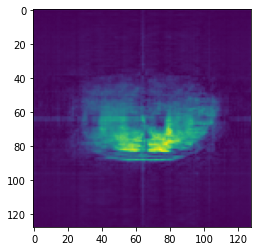

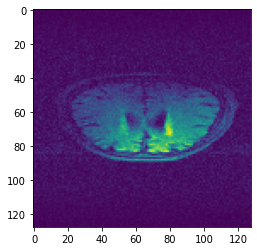

Time taken for epoch:  583.611251115799
[0, 1]


In [ ]:
def train(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run

    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    logging.info(args)
    logging.info(model)

    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

        is_new_best = dev_loss < best_dev_loss
        best_dev_loss = min(best_dev_loss, dev_loss)
        save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
        print(f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} ',
        f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s')
        
        for iter, data in enumerate(train_loader):
            kspace, full = data
            input = kspace.to(f'{args.device}:{model.device_ids[0]}')
            target = full.to(f'{args.device}:{model.device_ids[0]}')
            output_r,output_i = model(input)
            output_r=output_r.to('cpu').detach().numpy()
            output_i=output_i.to('cpu').detach().numpy()
            output = output_r+output_i*1j
            image = abs(output.squeeze(1))
            #print(output)
            plt.imshow(image[0,:,:])
            plt.show()
            plt.imshow(target[0,:,:].to('cpu').detach().numpy())
            plt.show()
            break;
        
        logging.info(
            f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} '
            f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s',
        )
        print("Time taken for epoch: ",time.time()-ti)
    writer.close()
    return dev_loss
    
train(args)

In [27]:
#f ="/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelue_2020/best_model.pt"
checkpoint, model, optimizer = load_model(args.checkpoint,args)
model.eval()

Model build successfully
Model load successfully


DataParallel(
  (module): ComplexEndToEnd(
    (f_layer1): ComplexConv2d(
      (conv_r): Conv2d(1, 128, kernel_size=(1, 128), stride=(1, 1), bias=False)
      (conv_i): Conv2d(1, 128, kernel_size=(1, 128), stride=(1, 1), bias=False)
    )
    (f_layer2): ComplexConv2d(
      (conv_r): Conv2d(1, 128, kernel_size=(1, 128), stride=(1, 1), bias=False)
      (conv_i): Conv2d(1, 128, kernel_size=(1, 128), stride=(1, 1), bias=False)
    )
    (down_sample_layers): ModuleList(
      (0): ConvBlock(in_chans=1, out_chans=32, drop_prob=0.0)
      (1): ConvBlock(in_chans=32, out_chans=64, drop_prob=0.0)
      (2): ConvBlock(in_chans=64, out_chans=128, drop_prob=0.0)
      (3): ConvBlock(in_chans=128, out_chans=256, drop_prob=0.0)
    )
    (conv): ConvBlock(in_chans=256, out_chans=512, drop_prob=0.0)
    (up_conv): ModuleList(
      (0): ConvBlock(in_chans=512, out_chans=256, drop_prob=0.0)
      (1): ConvBlock(in_chans=256, out_chans=128, drop_prob=0.0)
      (2): ConvBlock(in_chans=128, out_cha

module.f_layer1.conv_r.weight tensor([[[[-0.0008,  0.0027,  0.0106,  ...,  0.0024,  0.0184, -0.0002]]],


        [[[ 0.0010,  0.0024,  0.0099,  ...,  0.0011,  0.0129,  0.0054]]],


        [[[-0.0055,  0.0007, -0.0071,  ..., -0.0011, -0.0032,  0.0106]]],


        ...,


        [[[ 0.0059, -0.0062, -0.0028,  ..., -0.0061, -0.0035, -0.0053]]],


        [[[-0.0025, -0.0001, -0.0131,  ..., -0.0014, -0.0096,  0.0050]]],


        [[[ 0.0008, -0.0006, -0.0099,  ...,  0.0006, -0.0138, -0.0055]]]],
       device='cuda:0', dtype=torch.float64)


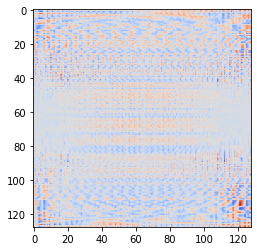

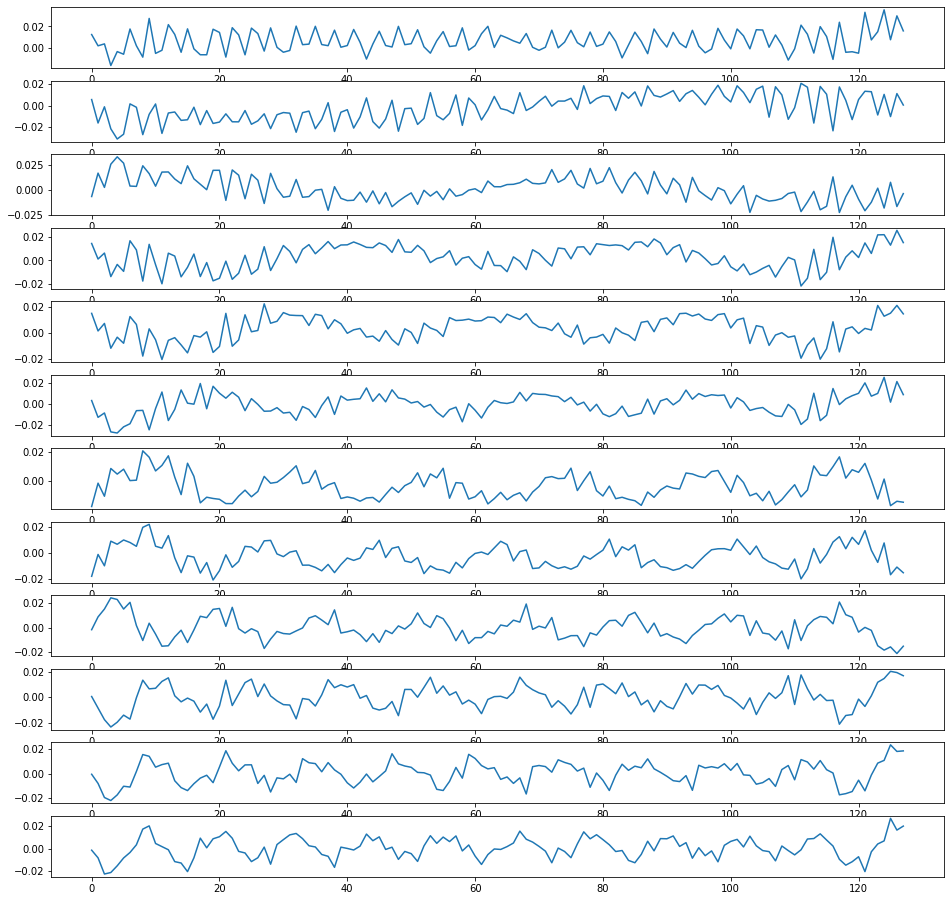

module.f_layer1.conv_i.weight tensor([[[[ 0.0013, -0.0006,  0.0040,  ...,  0.0021, -0.0012, -0.0059]]],


        [[[-0.0054,  0.0033,  0.0048,  ...,  0.0050,  0.0027,  0.0026]]],


        [[[ 0.0008,  0.0032,  0.0106,  ...,  0.0012,  0.0129,  0.0050]]],


        ...,


        [[[ 0.0035,  0.0012,  0.0098,  ..., -0.0032,  0.0130, -0.0009]]],


        [[[-0.0024,  0.0041,  0.0050,  ...,  0.0034,  0.0093,  0.0133]]],


        [[[ 0.0060, -0.0043, -0.0055,  ..., -0.0057, -0.0041, -0.0053]]]],
       device='cuda:0', dtype=torch.float64)


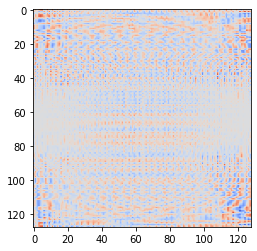

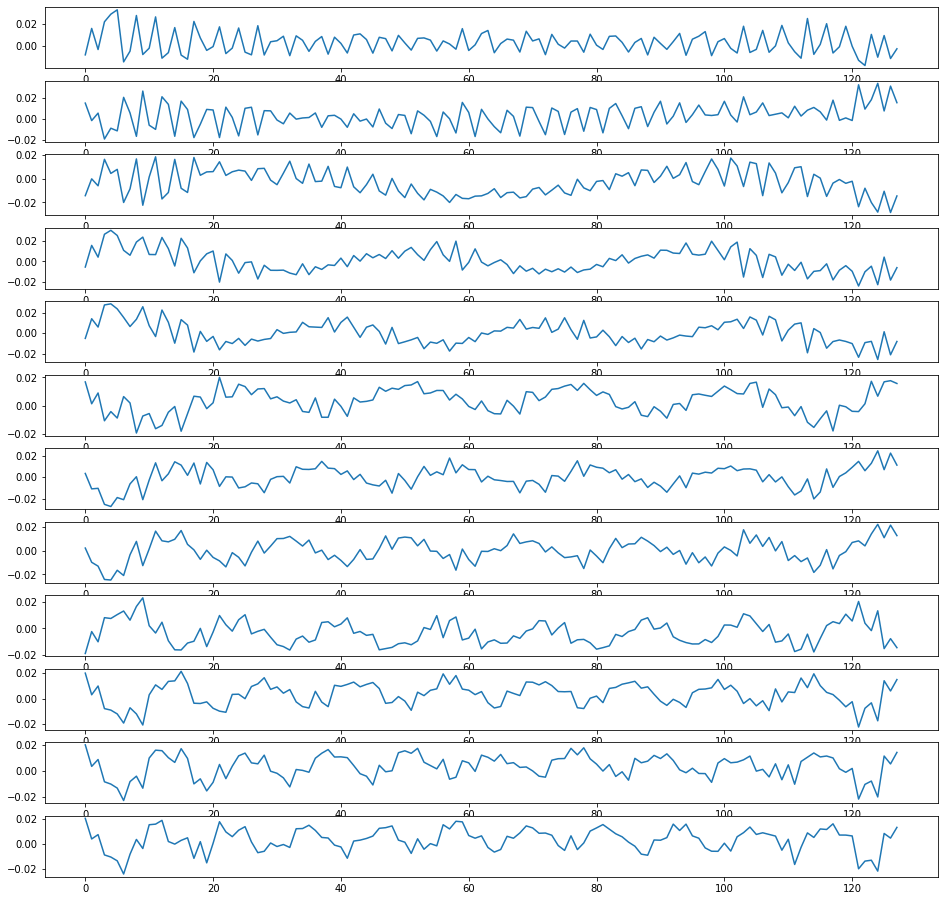

module.f_layer2.conv_r.weight tensor([[[[ 0.0032, -0.0024,  0.0033,  ..., -0.0030,  0.0059, -0.0043]]],


        [[[ 0.0027, -0.0039,  0.0027,  ..., -0.0013,  0.0004, -0.0030]]],


        [[[ 0.0023, -0.0045,  0.0030,  ..., -0.0041,  0.0016, -0.0058]]],


        ...,


        [[[-0.0016,  0.0045, -0.0046,  ...,  0.0056, -0.0034,  0.0059]]],


        [[[ 0.0033, -0.0022,  0.0024,  ..., -0.0038,  0.0049, -0.0024]]],


        [[[-0.0039,  0.0030, -0.0019,  ...,  0.0016, -0.0002,  0.0043]]]],
       device='cuda:0', dtype=torch.float64)


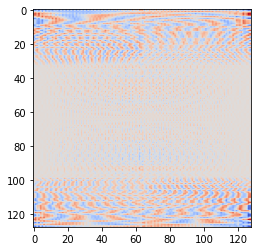

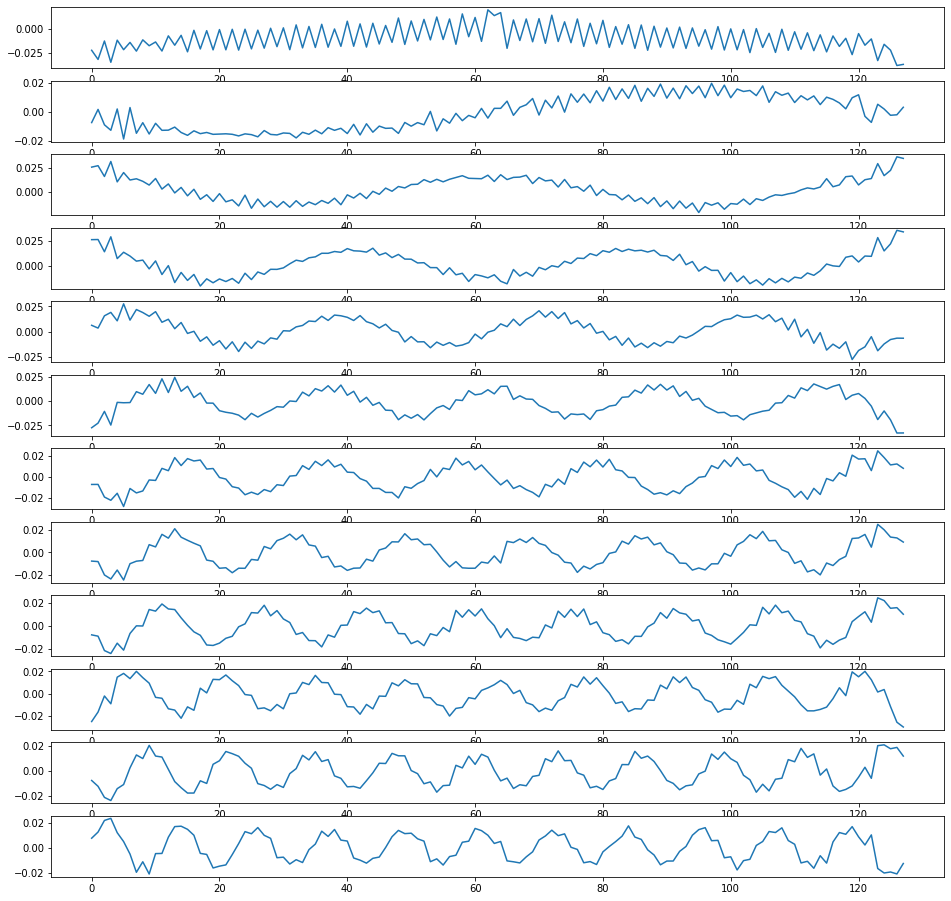

module.f_layer2.conv_i.weight tensor([[[[-0.0001, -0.0012,  0.0022,  ..., -0.0011,  0.0002, -0.0051]]],


        [[[-0.0066,  0.0044, -0.0062,  ...,  0.0045, -0.0054,  0.0050]]],


        [[[ 0.0025, -0.0043,  0.0040,  ..., -0.0030,  0.0020, -0.0051]]],


        ...,


        [[[ 0.0057, -0.0049,  0.0067,  ..., -0.0036,  0.0050, -0.0035]]],


        [[[-0.0048,  0.0057, -0.0055,  ...,  0.0042, -0.0022,  0.0055]]],


        [[[ 0.0051, -0.0047,  0.0062,  ..., -0.0030,  0.0051, -0.0041]]]],
       device='cuda:0', dtype=torch.float64)


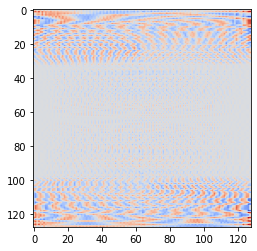

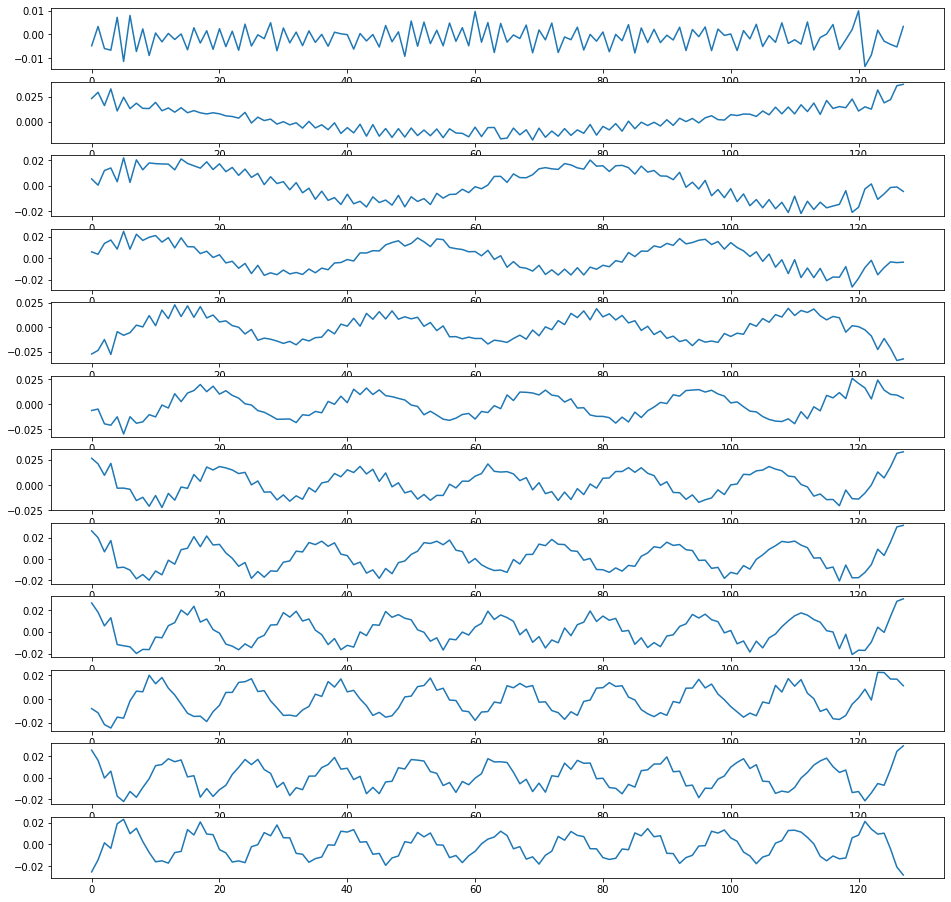

module.down_sample_layers.0.layers.0.conv_r.weight tensor([[[[-3.3170e-01, -9.7455e-02, -2.2082e-01],
          [ 1.2147e-01,  1.0939e-01, -8.6994e-02],
          [ 2.6265e-01,  1.6638e-02, -1.0762e-01]]],


        [[[ 2.4460e-02,  6.6318e-02,  1.8645e-01],
          [-3.0475e-01, -5.3695e-02,  8.8622e-02],
          [-1.3586e-01,  1.7938e-01, -1.5423e-01]]],


        [[[-1.7216e-01,  1.3778e-01, -3.2958e-01],
          [ 1.7719e-01,  4.5424e-02,  2.4568e-01],
          [ 2.3805e-01, -6.2461e-02,  2.8250e-01]]],


        [[[ 9.6144e-02,  1.5098e-01,  8.1185e-02],
          [-3.1901e-01, -1.4881e-01, -1.9114e-01],
          [-4.8717e-03, -2.9510e-01,  1.3070e-01]]],


        [[[ 1.9638e-01, -1.2320e-01,  2.8651e-01],
          [ 1.7882e-01,  2.8639e-01, -2.3327e-02],
          [ 3.2222e-01, -3.3468e-02,  6.1075e-02]]],


        [[[-2.7436e-01, -1.0363e-02,  1.6719e-01],
          [ 3.2393e-01, -2.7850e-02, -2.1121e-01],
          [ 2.9523e-01,  1.0708e-01,  2.6086e-01]]],


       

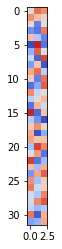

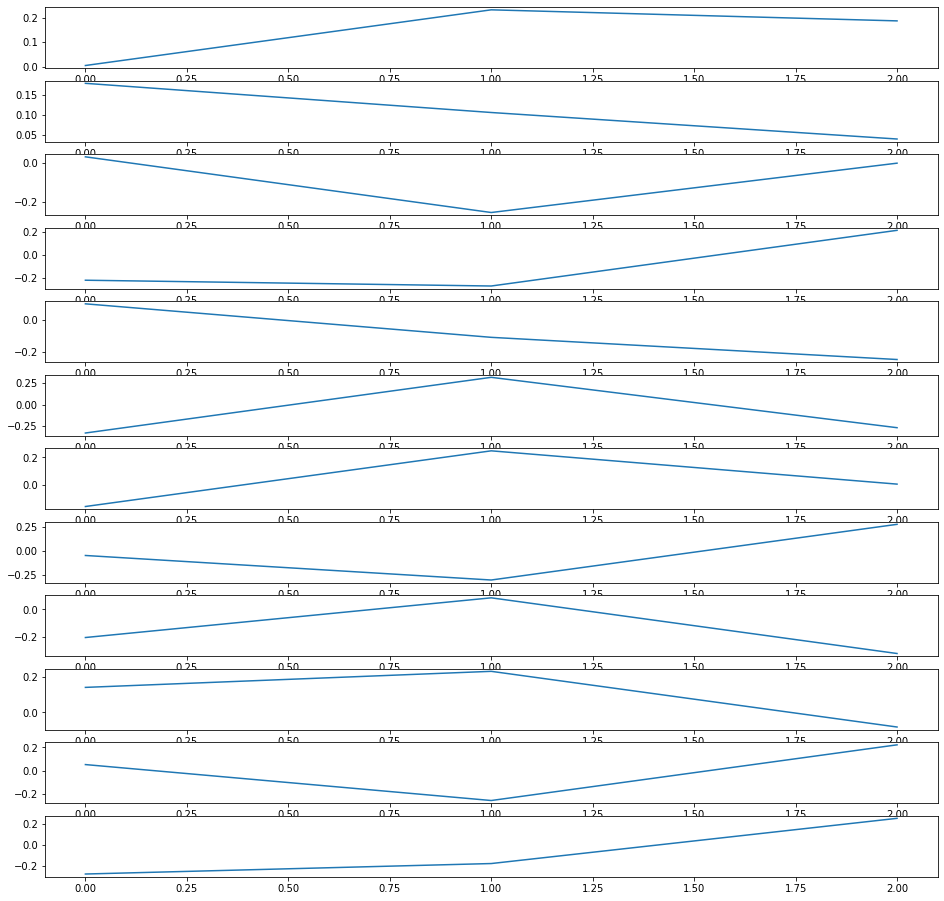

module.down_sample_layers.0.layers.0.conv_i.weight tensor([[[[ 9.8628e-02,  3.0738e-02,  3.2909e-01],
          [ 1.3220e-01, -3.1731e-01, -2.2661e-01],
          [ 1.9169e-02,  4.1789e-02, -1.2110e-01]]],


        [[[ 8.2914e-02, -2.6048e-01, -2.8475e-01],
          [-1.9416e-01, -3.1484e-01,  2.2359e-01],
          [ 8.1169e-02, -1.8979e-02,  2.5165e-01]]],


        [[[-2.9057e-01,  3.4541e-01, -2.4930e-01],
          [ 2.7530e-01, -1.5989e-01,  1.3260e-01],
          [ 6.4710e-02,  1.1436e-01,  1.9264e-01]]],


        [[[-2.9380e-01, -2.4763e-01, -1.9339e-01],
          [ 3.2259e-01, -2.0764e-01, -8.3645e-02],
          [ 3.1463e-01, -3.3635e-02, -2.6587e-01]]],


        [[[ 2.5850e-01,  1.8748e-01,  1.5345e-02],
          [-2.1162e-01, -7.5001e-02,  7.9768e-03],
          [ 3.4055e-01,  1.9741e-01, -2.6694e-01]]],


        [[[-1.8460e-01, -2.9855e-02, -1.1477e-01],
          [ 3.2913e-01, -8.2111e-02, -2.5121e-01],
          [-1.6152e-01,  2.7514e-02,  1.1114e-01]]],


       

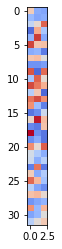

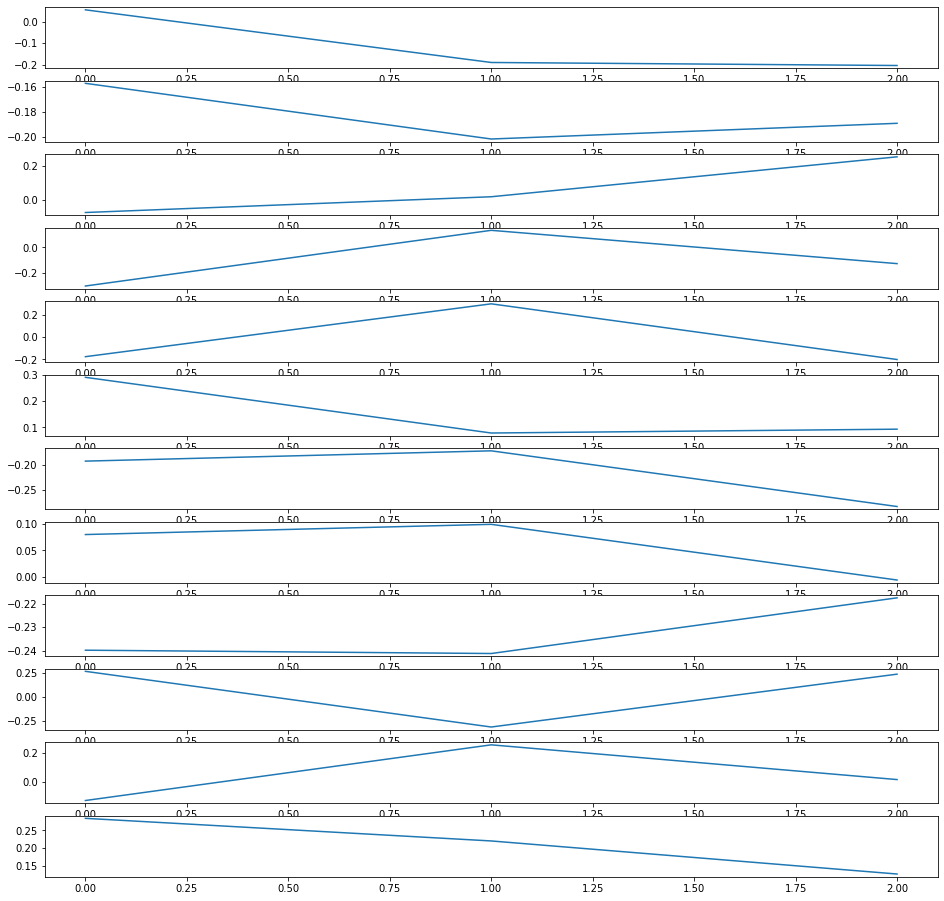

module.down_sample_layers.0.layers.1.weight tensor([[ 1.4172e+00,  1.4196e+00,  1.1792e-02],
        [ 1.4128e+00,  1.4171e+00,  1.4085e-02],
        [ 1.4155e+00,  1.4111e+00,  3.9718e-03],
        [ 1.4116e+00,  1.4138e+00, -4.6290e-03],
        [ 1.4088e+00,  1.4079e+00, -1.1719e-03],
        [ 1.4141e+00,  1.4127e+00, -4.4741e-03],
        [ 1.4148e+00,  1.4125e+00, -3.5610e-03],
        [ 1.4124e+00,  1.4097e+00, -4.9484e-03],
        [ 1.4152e+00,  1.4143e+00, -1.0295e-03],
        [ 1.4195e+00,  1.4228e+00,  2.2112e-03],
        [ 1.4213e+00,  1.4143e+00,  1.0519e-03],
        [ 1.4185e+00,  1.4144e+00,  7.8666e-04],
        [ 1.4194e+00,  1.4218e+00, -4.3044e-03],
        [ 1.4192e+00,  1.4190e+00, -7.6774e-03],
        [ 1.4110e+00,  1.4146e+00, -3.8353e-03],
        [ 1.4152e+00,  1.4161e+00,  1.4238e-04],
        [ 1.4054e+00,  1.4095e+00, -2.6709e-03],
        [ 1.4191e+00,  1.4161e+00,  6.4102e-03],
        [ 1.4198e+00,  1.4146e+00, -9.2778e-03],
        [ 1.4104e+00,  1.

IndexError: too many indices for tensor of dimension 2

In [28]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        #plt.imshow(nf.ifftshift(param.data.cpu()[:,0,0,:]), vmin=-1, vmax=1, cmap='coolwarm')
        # Heat map of neuron weights
        weights=nf.ifftshift(param.data.cpu()[:,0,0,:])
        plt.imshow(weights, vmin=np.min(param.data.cpu().numpy()), vmax=np.max(param.data.cpu().numpy()), cmap='coolwarm')
        plt.show()
        fig,ax=plt.subplots(args.resolution//10,1,figsize=(16,16))
        for i in range(args.resolution//10):
            ax[i].plot(weights[i,:args.resolution])
        plt.show()

In [ ]:
def train_plain(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run
    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        ti=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

#         is_new_best = dev_loss < best_dev_loss
#         best_dev_loss = min(best_dev_loss, dev_loss)
#         save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
    writer.close()
    return dev_loss

def run_model(lr):
    print(lr)
    args.lr=lr
    return train_plain(args)

In [ ]:
from hyperopt import hp, tpe, fmin

# Single line bayesian optimization of polynomial function
args.num_epochs=100
best = fmin(fn=lambda x: run_model(x),
            space=hp.normal('x', 0.0001, 0.5),
            algo=tpe.suggest,
            max_evals=100)

In [ ]:
print(best)

In [63]:
c=args.checkpoint#"/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_pure_inverse_fourier/best_model.pt
print(c)
#c='/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd'+'/model.pt'
checkpoint, model, optimizer = load_model(c,args)
model.eval()
losses=[]
torch.cuda.empty_cache()
for iter, data in enumerate(train_loader):
    with torch.no_grad():
            f, t = data
            #plt.hist(f[abs(f) >= 0.00001].flatten(),bins=1000)
            #plt.show()
            #plt.imshow(abs(nu.make_ift(nu.to_complex(f)))[0,0,:,:])
            #plt.show()
            
            input = f.to(f'{args.device}:{model.device_ids[0]}')
            target = t.to(f'{args.device}:{model.device_ids[0]}')
            
            output_r,output_i = model(input)
            l=eval_loss((output_r.squeeze(1)**2+output_i.squeeze(1)**2)**(1/2),target)
            losses.append(l)
            output_r=output_r.to('cpu').detach().numpy()
            output_i=output_i.to('cpu').detach().numpy()
            output = output_r+output_i*1j
            image = abs(output.squeeze(1))
            #print(output)
            #plt.imshow(image[0,:,:])
            #plt.show()

            #plt.imshow(target[0,:,:].to('cpu').detach().numpy())
            #plt.show()
            #break;
losses=np.array(losses)
print(np.mean(losses[:,0]),np.mean(losses[:,1]),np.mean(losses[:,2]),np.mean(losses[:,3]),\
      np.min(losses[:,0]),np.min(losses[:,1]),np.min(losses[:,2]),np.min(losses[:,3]),\
      np.max(losses[:,0]),np.max(losses[:,1]),np.max(losses[:,2]),np.max(losses[:,3]))
print(np.std(losses[:,0]),np.std(losses[:,1]),np.std(losses[:,2]),np.std(losses[:,3]))

/mnt/mnt/5TB_slot2/Tobias/Thesis/FF_lrelu_ComplexEndToEnd_Kspace/best_model.pt
Model build successfully
Model load successfully
torch.Size([2, 128, 128]) torch.Size([2, 128, 128])
0.029869570148138222 0.00252661548138344 0.8277784199567485 0.01720250808289054 0.05606445577688123 0.0007861655509907573 0.008640449317607032 0.6891437560644379 0.9180932997739275


In [6]:
def test_fourier():
    sig = np.random.randn(args.resolution) + 1j*np.random.randn(320)
    F = np.fft.ifft(sig, axis=-1)
    # First half of inputs/outputs is real part, second half is imaginary part
    X = torch.from_numpy(np.hstack([sig.real, sig.imag])).double()
    Y = torch.from_numpy((F.real**2+F.imag**2)**(1/2)).double()
    return X,Y